<a href="https://colab.research.google.com/github/jhChoi1997/KSNVE-AI-2022-summer/blob/main/code/10_DCASE2020_ResNet_slider.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2022년 인공지능 강습회 2일차 실습 코드**
## **Practice 10 : Prediction-based Unsupervised Detection of Anomalous Sounds for Machine Condition Monitoring (DCASE 2020 ResNet)**

**Description**

Anomalous Sound Detection (ASD) is the task to identify whether the sound emmited from a target machine is normal or anomalous. 
The main challenge of this task is to detect unknown anomalous sounds under the condition that only normal sound samples have been provided as training data. 💻




# 0. Google Drive Mounting

**[Important!]**
Before running this code, you need to upload the train dataset and test dataset to your Google drive. You can download `slider_train` and `slider_test` from provided links.

`slider_train` : https://drive.google.com/file/d/1j5N4mLgOZxKwVnb01Pq4r7iRJeVyLgW_/view?usp=sharing


`slider_test` : https://drive.google.com/file/d/1z2MmGaWFcv9bgkf8zxeWCSGVZ_swQhLR/view?usp=sharing

Download both `.zip` files and upload them to your Google drive. Your root path of Google drive would be `gdrive/MyDrive/`, so if you upload to other paths, you need to change `root_path` in the code below.

In [ ]:
!gdown https://drive.google.com/uc?id=1j5N4mLgOZxKwVnb01Pq4r7iRJeVyLgW_         # slider train
!gdown https://drive.google.com/uc?id=1z2MmGaWFcv9bgkf8zxeWCSGVZ_swQhLR         # slider test

!unzip -qq -n slider_train.zip -d ./slider_train/                               # unzip slider train
!unzip -qq -n slider_test.zip -d ./slider_test/                                 # unzip slider test

!pip install torchinfo                                                          # install torchinfo module

Downloading...
From: https://drive.google.com/uc?id=1j5N4mLgOZxKwVnb01Pq4r7iRJeVyLgW_
To: /content/slider_train.zip
100% 694M/694M [00:03<00:00, 200MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z2MmGaWFcv9bgkf8zxeWCSGVZ_swQhLR
To: /content/slider_test.zip
100% 323M/323M [00:02<00:00, 156MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Import Packages

New library imported for this project:


*   `librosa`: a python package for music and audio analysis (https://librosa.org/doc/latest/index.html)
  - We use to get spectrograms from sound data
*   `glob`: package to reading files

In [ ]:
import os
import sys
import librosa
import librosa.core
import librosa.feature
import librosa.display
import glob
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
from torchinfo import summary
import IPython.display as ipd

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


# 2. Hyperparameters

Set dataset folder path and hyperparameters.

In [ ]:
# Dataset path setting
dataset_dir = './slider_train'
test_dir = './slider_test'
model_dir = './model'

# Parameters for mel-spectrogram
n_fft = 2048
hop_length = 512
n_mels = 128
power = 2

# Parameters for ResNet
kernel_size = 3

# Training parameters
EPOCHS = 20
BATCH = 32

# 3. Function Definition

For the convenience of the code, we define some functions below here.

- `file_load` : reads one 10-sec sound file and returns 1D array `y` and sampling rate `sr`

- `file_list_generator` : returns file_name list in `target_dir`

- `file_to_log_mel` : convert one file to log-mel spectrogram for use as input to the model

- `list_to_dataset` : returns a total dataset of train data


In [ ]:
def file_load(wav_name):
  try:
    return librosa.load(wav_name, sr=None, mono=False)
  except:
    print('file_broken or not exists!! : {}'.format(wav_name))
    

def file_list_generator(target_dir):
  training_list_path = os.path.abspath('{dir}/*.wav'.format(dir=target_dir))
  files = sorted(glob.glob(training_list_path))
  if len(files) == 0:
    print('no_wav_file!!')
  return files


def file_to_log_mel(file_name, n_mels, n_fft, hop_length, power):
  y, sr = file_load(file_name)
  mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                   sr=sr,
                                                   n_fft=n_fft,
                                                   hop_length=hop_length,
                                                   n_mels=n_mels,
                                                   power=power)
  log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)
  return log_mel_spectrogram


def list_to_dataset(file_list, n_mels, n_fft, hop_length, power):
  for idx in tqdm(range(len(file_list))):
    log_mel = file_to_log_mel(file_list[idx],
                              n_mels=n_mels,
                              n_fft=n_fft,
                              hop_length=hop_length,
                              power=power)
    if idx == 0:
      dataset = np.zeros((len(file_list), 1, len(log_mel[:,0]), len(log_mel[0,:])), float)
    dataset[idx, 0, :, :] = log_mel
  return dataset

# 4. Dataset and Dataloader

Create a train dataset using the functions defined above.

In [ ]:
# os.makedirs(model_dir, exist_ok=True)
dataset_dir = os.path.abspath(dataset_dir)
machine_type = os.path.split(dataset_dir)[1]
model_file_path = '{model}/model_{machine_type}'.format(model=model_dir, machine_type=machine_type)

files = file_list_generator(dataset_dir)
train_data = list_to_dataset(files,
                             n_mels=n_mels,
                             n_fft=n_fft,
                             hop_length=hop_length,
                             power=power)


100%|██████████| 2804/2804 [01:23<00:00, 33.76it/s]


  4-1. Generate Train Label

  Create a data label. In `valve` dataset, there exists four classes: `id_00`, `id_02`, `id_04`, `id_06`. It can be converted to a one-hot vector.

In [ ]:
label_list = ['id_00', 'id_02', 'id_04', 'id_06']
train_label = torch.LongTensor([idx for file_name in files for idx, label_idx in enumerate(label_list) if label_idx in file_name])
train_label = nn.functional.one_hot(train_label, num_classes=len(label_list))

In [ ]:
train_data = torch.Tensor(train_data)
train_dataset = TensorDataset(train_data, train_label)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)

# 5. Define a Classification Model (ResNet)

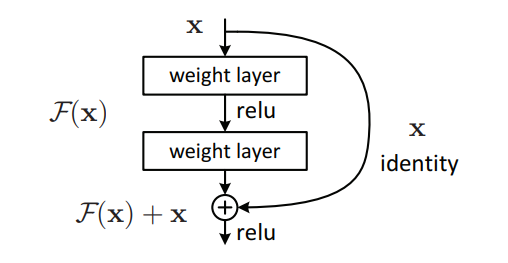

ResNet is a classification model to ease the training of networks that are substantially deeper than those used previously. Deep networks naturally integrate low/mid/high-level features and classifiers in an end-to-end multi-layer fashion, and many other non-trivial visual recognition tasks have also greatly benefited from very deep models.

When deeper networks are able to start converging, a degradation problem has been exposed. Unexpectedly, such degradation is not caused by overfitting, and adding more layers to a suitably deep model leads to higher training error. It can be solved by adding identity mapping layers to the learned shallower model.

For more details, you can refer to the ResNet paper: https://arxiv.org/pdf/1512.03385.pdf


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channel, out_channel, projection=False):
        super(ResidualBlock, self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.projection = projection
        if self.projection:
            self.conv1 = nn.Conv2d(self.in_channel, self.out_channel, kernel_size=3, stride=2, padding=(1, 1))
        else:
            self.conv1 = nn.Conv2d(self.in_channel, self.out_channel, kernel_size=3, padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(self.out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(self.out_channel, self.out_channel, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(self.out_channel)
        if self.projection:
            self.downsample = nn.Conv2d(self.in_channel, self.out_channel, stride=2, kernel_size=1)
        else:
            self.downsample = nn.Conv2d(self.in_channel, self.out_channel, kernel_size=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.projection:
            skip = self.downsample(x)
        else:
            skip = x
        out += skip
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, n_class):
        super(ResNet, self).__init__()
        self.n_channel = 8
        self.n_class = n_class
        self.conv1 = nn.Conv2d(1, self.n_channel, kernel_size=7, stride=2, padding=(3, 2))
        self.bn1 = nn.BatchNorm2d(self.n_channel)
        self.relu = nn.ReLU()
        self.pooling1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=(1, 1))
        self.block1 = ResidualBlock(self.n_channel, self.n_channel)
        self.block2 = ResidualBlock(self.n_channel, self.n_channel)
        self.block3 = ResidualBlock(self.n_channel, self.n_channel * 2, True)
        self.block4 = ResidualBlock(self.n_channel * 2, self.n_channel * 2)
        self.block5 = ResidualBlock(self.n_channel * 2, self.n_channel * 4, True)
        self.block6 = ResidualBlock(self.n_channel * 4, self.n_channel * 4)
        self.block7 = ResidualBlock(self.n_channel * 4, self.n_channel * 8, True)
        self.block8 = ResidualBlock(self.n_channel * 8, self.n_channel * 8)
        self.gap1 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.n_channel * 8, self.n_class)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pooling1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.gap1(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
model = ResNet(len(label_list)).to(device)
summary(model, input_size=(BATCH, 1, n_mels, 313))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 4]                   --
├─Conv2d: 1-1                            [32, 8, 64, 156]          400
├─BatchNorm2d: 1-2                       [32, 8, 64, 156]          16
├─ReLU: 1-3                              [32, 8, 64, 156]          --
├─MaxPool2d: 1-4                         [32, 8, 32, 78]           --
├─ResidualBlock: 1-5                     [32, 8, 32, 78]           72
│    └─Conv2d: 2-1                       [32, 8, 32, 78]           584
│    └─BatchNorm2d: 2-2                  [32, 8, 32, 78]           16
│    └─ReLU: 2-3                         [32, 8, 32, 78]           --
│    └─Conv2d: 2-4                       [32, 8, 32, 78]           584
│    └─BatchNorm2d: 2-5                  [32, 8, 32, 78]           16
│    └─ReLU: 2-6                         [32, 8, 32, 78]           --
├─ResidualBlock: 1-6                     [32, 8, 32, 78]           72
│    └─Conv2

# 6. Define a Loss Function & Optimizers

ResNet predicts the probabilistic classification output, so the loss function of ResNet is cross-entropy loss.

In [ ]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 7. Train

Define a `train` function.

In [ ]:
def train(dataloader, mdoel, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    X = X.to(device)
    y = y.float().to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 30 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>5f}  [{current:>5d}/{size:>5d}]")

Model Training

In [ ]:
for t in range(EPOCHS):
  print(f"Epoch {t + 1}\n-------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)

Epoch 1
-------------------------------
loss: 1.450280  [    0/ 2804]
loss: 0.696397  [  960/ 2804]
loss: 0.425894  [ 1920/ 2804]
Epoch 2
-------------------------------
loss: 0.449555  [    0/ 2804]
loss: 0.399360  [  960/ 2804]
loss: 0.457471  [ 1920/ 2804]
Epoch 3
-------------------------------
loss: 0.494162  [    0/ 2804]
loss: 0.361890  [  960/ 2804]
loss: 0.358781  [ 1920/ 2804]
Epoch 4
-------------------------------
loss: 0.376729  [    0/ 2804]
loss: 0.373932  [  960/ 2804]
loss: 0.360388  [ 1920/ 2804]
Epoch 5
-------------------------------
loss: 0.357621  [    0/ 2804]
loss: 0.371623  [  960/ 2804]
loss: 0.450946  [ 1920/ 2804]
Epoch 6
-------------------------------
loss: 0.368767  [    0/ 2804]
loss: 0.355461  [  960/ 2804]
loss: 0.358766  [ 1920/ 2804]
Epoch 7
-------------------------------
loss: 0.370170  [    0/ 2804]
loss: 0.362230  [  960/ 2804]
loss: 0.356642  [ 1920/ 2804]
Epoch 8
-------------------------------
loss: 0.358703  [    0/ 2804]
loss: 0.354203  [  9

# 8. Test Dataset Generation

In [ ]:
normal_files = sorted(glob.glob('{dir}/normal_*'.format(dir=test_dir)))
anomaly_files = sorted(glob.glob('{dir}/anomaly_*'.format(dir=test_dir)))

normal_labels = np.zeros(len(normal_files))
anomaly_labels = np.ones(len(anomaly_files))

test_files = np.concatenate((normal_files, anomaly_files), axis=0)
y_true = np.concatenate((normal_labels, anomaly_labels), axis=0)
y_pred = [0. for k in test_files]

In [ ]:
test_dataset = list_to_dataset(test_files, n_mels, n_fft, hop_length, power)

test_label = torch.LongTensor([idx for file_name in test_files for idx, label_idx in enumerate(label_list) if label_idx in file_name])
test_label = nn.functional.one_hot(test_label, num_classes=len(label_list))

100%|██████████| 1290/1290 [00:29<00:00, 44.18it/s]


In [ ]:
def get_anomaly_score(true, pred):
  anomaly_score = nn.CrossEntropyLoss()(pred, true)
  return anomaly_score

# 9. Test

Model test with test dataset

In [ ]:
for file_idx in tqdm(range(len(test_files)), desc='test data '):
  data = torch.Tensor(test_dataset[file_idx]).unsqueeze(0).to(device)
  output = model(data)

  true = test_label[file_idx].float().unsqueeze(0).to(device)
  score = get_anomaly_score(true, output)
  y_pred[file_idx] = score.cpu().detach().numpy()

test data : 100%|██████████| 1290/1290 [00:06<00:00, 202.66it/s]


Text(0, 0.5, 'TPR')

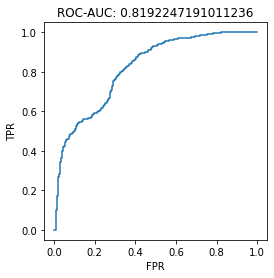

In [ ]:
auc = metrics.roc_auc_score(y_true, y_pred)
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr)
plt.title('ROC-AUC: {}'.format(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')

# 10. Image Comparison

You can see input data and reconstructed output of sound data.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Predicted Probability')

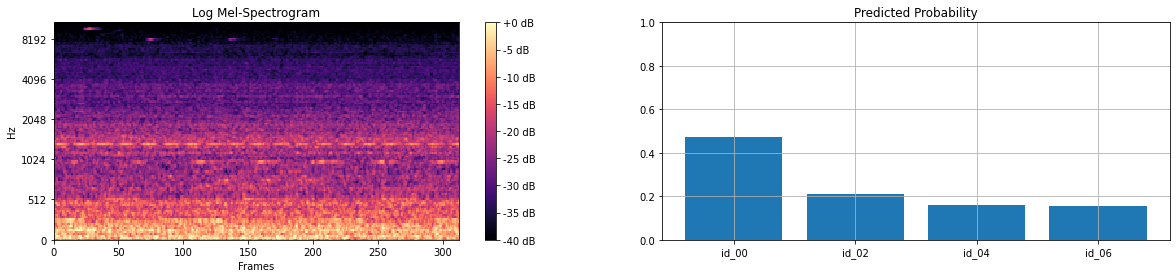

In [ ]:
normal_data = './slider_test/normal_id_00_00000000.wav'
normal_log_mel = file_to_log_mel(normal_data, n_mels, n_fft, hop_length, power)
normal_output = model(torch.Tensor(normal_log_mel).unsqueeze(0).unsqueeze(0).to(device))
normal_prob = torch.nn.functional.softmax(normal_output[0]).detach().cpu().numpy()

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(normal_log_mel, cmap=plt.get_cmap('magma'), vmin=-40, vmax=0, x_axis='frames', y_axis='mel')
plt.title('Log Mel-Spectrogram')
plt.colorbar(format='%+2.f dB')

plt.subplot(1, 2, 2)
x_list = np.arange(len(label_list))
plt.bar(x_list, normal_prob)
plt.xticks(x_list, label_list)
plt.ylim([0, 1])
plt.grid()
plt.title('Predicted Probability')

**[Anomaly data]**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Predicted Probability')

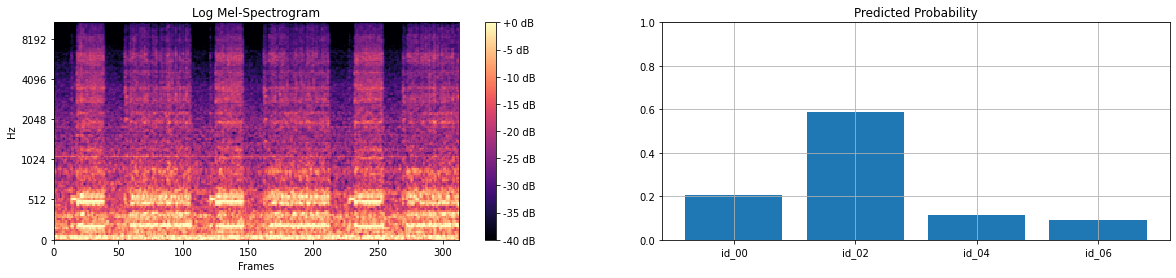

In [ ]:
anomaly_data = './slider_test/anomaly_id_00_00000000.wav'
anomaly_log_mel = file_to_log_mel(anomaly_data, n_mels, n_fft, hop_length, power)
anomaly_output = model(torch.Tensor(anomaly_log_mel).unsqueeze(0).unsqueeze(0).to(device))
anomaly_prob = torch.nn.functional.softmax(anomaly_output[0]).detach().cpu().numpy()

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(anomaly_log_mel, cmap=plt.get_cmap('magma'), vmin=-40, vmax=0, x_axis='frames', y_axis='mel')
plt.title('Log Mel-Spectrogram')
plt.colorbar(format='%+2.f dB')

plt.subplot(1, 2, 2)
x_list = np.arange(len(label_list))
plt.bar(x_list, anomaly_prob)
plt.xticks(x_list, label_list)
plt.ylim([0, 1])
plt.grid()
plt.title('Predicted Probability')